In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

## 1. Load All Cleaned Datasets

In [3]:
# Define dataset paths (using absolute paths)
import os
base_path = '/home/anirudh-sharma/Desktop/music-genere-presentation'
datasets = {
    'FMA Small': os.path.join(base_path, 'data/feature-extraction-cleaned/fma_small_features_labeled.csv'),
    'FMA Medium': os.path.join(base_path, 'data/feature-extraction-cleaned/fma_medium_features_labeled.csv'),
    'GTZAN': os.path.join(base_path, 'data/feature-extraction-cleaned/gtzan_features.csv'),
    'Indian Music': os.path.join(base_path, 'data/feature-extraction-cleaned/indian_features.csv'),
    'Ludwig': os.path.join(base_path, 'data/feature-extraction-cleaned/ludwig_features.csv')
}

# Load all datasets
data = {}
for name, path in datasets.items():
    df = pd.read_csv(path)
    data[name] = df
    print(f"✓ Loaded {name}: {df.shape[0]:,} tracks, {df.shape[1]} features")

print(f"\n📊 Total tracks: {sum(df.shape[0] for df in data.values()):,}")

✓ Loaded FMA Small: 7,996 tracks, 76 features
✓ Loaded FMA Medium: 16,986 tracks, 76 features
✓ Loaded GTZAN: 999 tracks, 74 features
✓ Loaded Indian Music: 500 tracks, 75 features
✓ Loaded Ludwig: 11,293 tracks, 75 features

📊 Total tracks: 37,774
✓ Loaded Ludwig: 11,293 tracks, 75 features

📊 Total tracks: 37,774


## 2. Create Output Directory

In [4]:
# Create output directory
output_dir = os.path.join(base_path, 'results/step1.5-correlation-analysis')
os.makedirs(output_dir, exist_ok=True)
print(f"📁 Results will be saved to: {output_dir}")

📁 Results will be saved to: /home/anirudh-sharma/Desktop/music-genere-presentation/results/step1.5-correlation-analysis


## 3. Compute Correlation Matrices

We'll analyze correlations for:
1. **MFCC Mean features** (mfcc1_mean to mfcc20_mean)
2. **MFCC Std features** (mfcc1_std to mfcc20_std)
3. **All numerical features** (comprehensive view)

In [5]:
def compute_correlation_matrix(df, feature_pattern=None):
    """
    Compute correlation matrix for numerical features.
    If feature_pattern is provided, filter columns matching the pattern.
    """
    # Exclude non-numerical columns
    exclude_cols = ['file_path', 'dataset', 'label', 'subset', 'duration', 'sr']
    numerical_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Filter by pattern if provided
    if feature_pattern:
        numerical_cols = [col for col in numerical_cols if feature_pattern in col]
    
    # Compute correlation matrix
    corr_matrix = df[numerical_cols].corr()
    
    return corr_matrix

# Compute correlation matrices for each dataset
correlation_matrices = {}
mfcc_mean_matrices = {}
mfcc_std_matrices = {}

for name, df in data.items():
    # Full correlation matrix
    correlation_matrices[name] = compute_correlation_matrix(df)
    
    # MFCC mean features only
    mfcc_mean_cols = [col for col in df.columns if 'mfcc' in col and '_mean' in col]
    if mfcc_mean_cols:
        mfcc_mean_matrices[name] = df[mfcc_mean_cols].corr()
    
    # MFCC std features only
    mfcc_std_cols = [col for col in df.columns if 'mfcc' in col and '_std' in col]
    if mfcc_std_cols:
        mfcc_std_matrices[name] = df[mfcc_std_cols].corr()
    
    print(f"✓ {name}: Correlation matrix computed ({correlation_matrices[name].shape[0]} features)")

✓ FMA Small: Correlation matrix computed (70 features)
✓ FMA Medium: Correlation matrix computed (70 features)
✓ GTZAN: Correlation matrix computed (69 features)
✓ Indian Music: Correlation matrix computed (69 features)
✓ Ludwig: Correlation matrix computed (69 features)
✓ Ludwig: Correlation matrix computed (69 features)


## 4. Identify Highly Correlated Feature Pairs

Extract feature pairs with correlation coefficient > 0.9

In [6]:
def find_high_correlations(corr_matrix, threshold=0.9):
    """
    Find feature pairs with absolute correlation > threshold.
    Excludes self-correlations (diagonal = 1.0).
    """
    high_corr_pairs = []
    
    # Get upper triangle indices (avoid duplicates)
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                high_corr_pairs.append({
                    'Feature_1': corr_matrix.columns[i],
                    'Feature_2': corr_matrix.columns[j],
                    'Correlation': corr_value,
                    'Abs_Correlation': abs(corr_value)
                })
    
    # Convert to DataFrame and sort
    if high_corr_pairs:
        df_high_corr = pd.DataFrame(high_corr_pairs)
        df_high_corr = df_high_corr.sort_values('Abs_Correlation', ascending=False)
        return df_high_corr
    else:
        return pd.DataFrame(columns=['Feature_1', 'Feature_2', 'Correlation', 'Abs_Correlation'])

# Find high correlations for each dataset
high_correlations = {}
mfcc_mean_high_corr = {}

print("\n" + "="*80)
print("🔍 HIGH CORRELATION ANALYSIS (|r| > 0.9)")
print("="*80)

for name in data.keys():
    # All features
    high_correlations[name] = find_high_correlations(correlation_matrices[name], threshold=0.9)
    
    # MFCC mean features
    if name in mfcc_mean_matrices:
        mfcc_mean_high_corr[name] = find_high_correlations(mfcc_mean_matrices[name], threshold=0.9)
    
    print(f"\n{'='*80}")
    print(f"📊 {name}")
    print(f"{'='*80}")
    print(f"Total highly correlated pairs (all features): {len(high_correlations[name])}")
    print(f"MFCC mean highly correlated pairs: {len(mfcc_mean_high_corr.get(name, []))}")
    
    if len(high_correlations[name]) > 0:
        print(f"\nTop 10 highest correlations:")
        print(high_correlations[name].head(10).to_string(index=False))


🔍 HIGH CORRELATION ANALYSIS (|r| > 0.9)

📊 FMA Small
Total highly correlated pairs (all features): 2
MFCC mean highly correlated pairs: 0

Top 10 highest correlations:
         Feature_1         Feature_2  Correlation  Abs_Correlation
spec_centroid_mean spec_rolloff_mean     0.972431         0.972431
spec_centroid_mean        mfcc2_mean    -0.901017         0.901017

📊 FMA Medium
Total highly correlated pairs (all features): 3
MFCC mean highly correlated pairs: 0

Top 10 highest correlations:
         Feature_1         Feature_2  Correlation  Abs_Correlation
spec_centroid_mean spec_rolloff_mean     0.965904         0.965904
spec_centroid_mean        mfcc2_mean    -0.915689         0.915689
 spec_rolloff_mean        mfcc2_mean    -0.909472         0.909472

📊 GTZAN
Total highly correlated pairs (all features): 3
MFCC mean highly correlated pairs: 0

Top 10 highest correlations:
         Feature_1         Feature_2  Correlation  Abs_Correlation
spec_centroid_mean spec_rolloff_mean     0

## 5. Visualize Correlation Heatmaps

### 5.1 MFCC Mean Features Correlation


📊 Generating MFCC Mean Correlation Heatmaps...

✓ Saved: correlation_mfcc_mean_fma_small.png
✓ Saved: correlation_mfcc_mean_fma_small.png


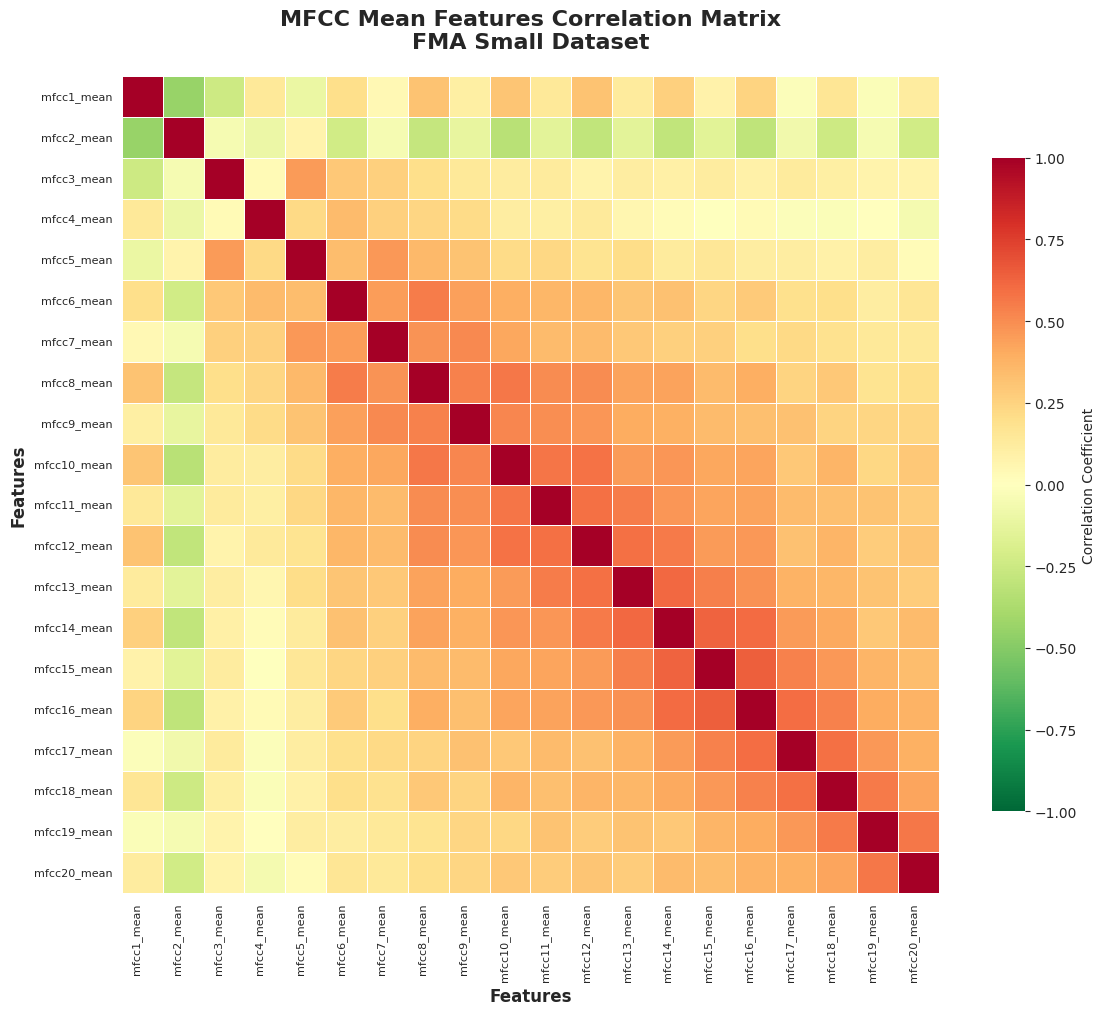

✓ Saved: correlation_mfcc_mean_fma_medium.png


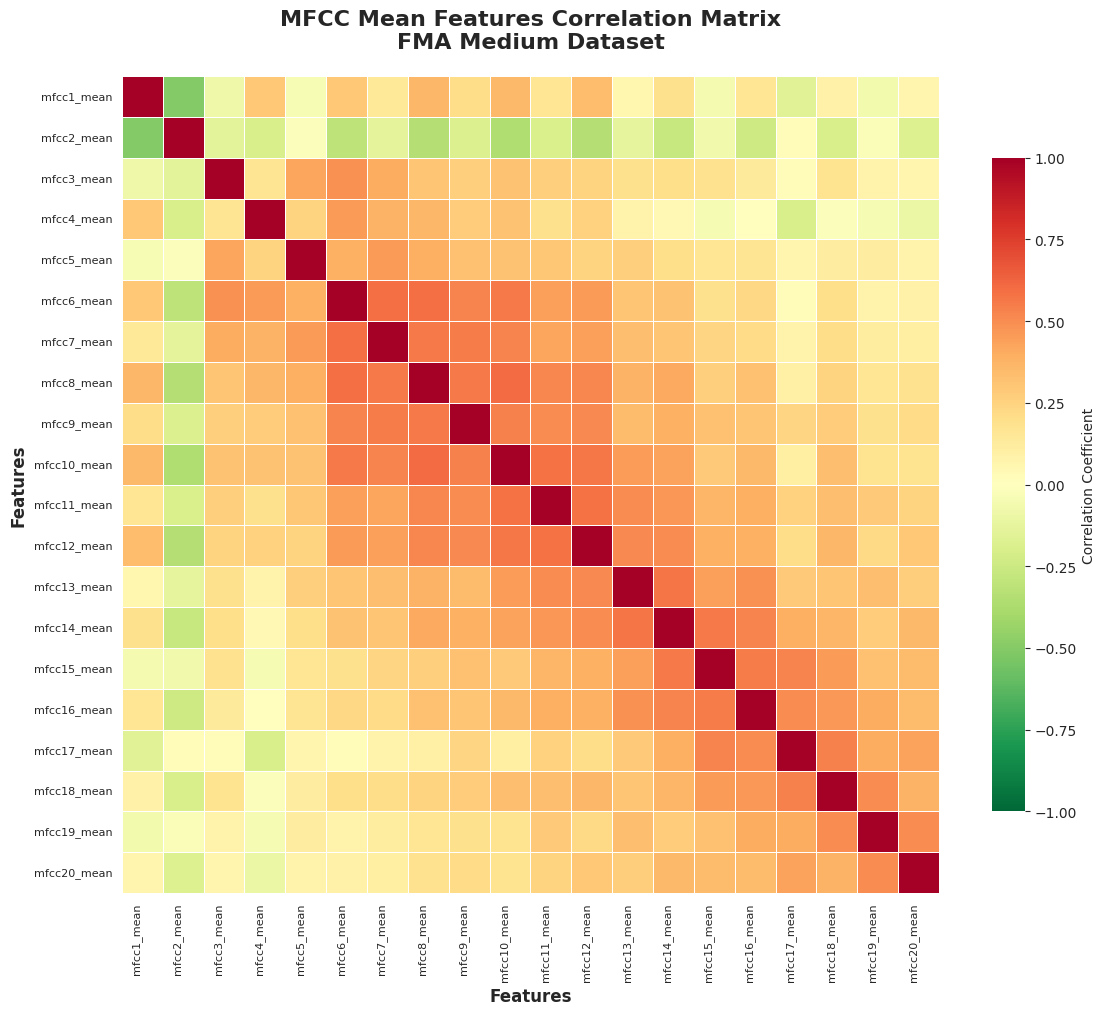

✓ Saved: correlation_mfcc_mean_gtzan.png


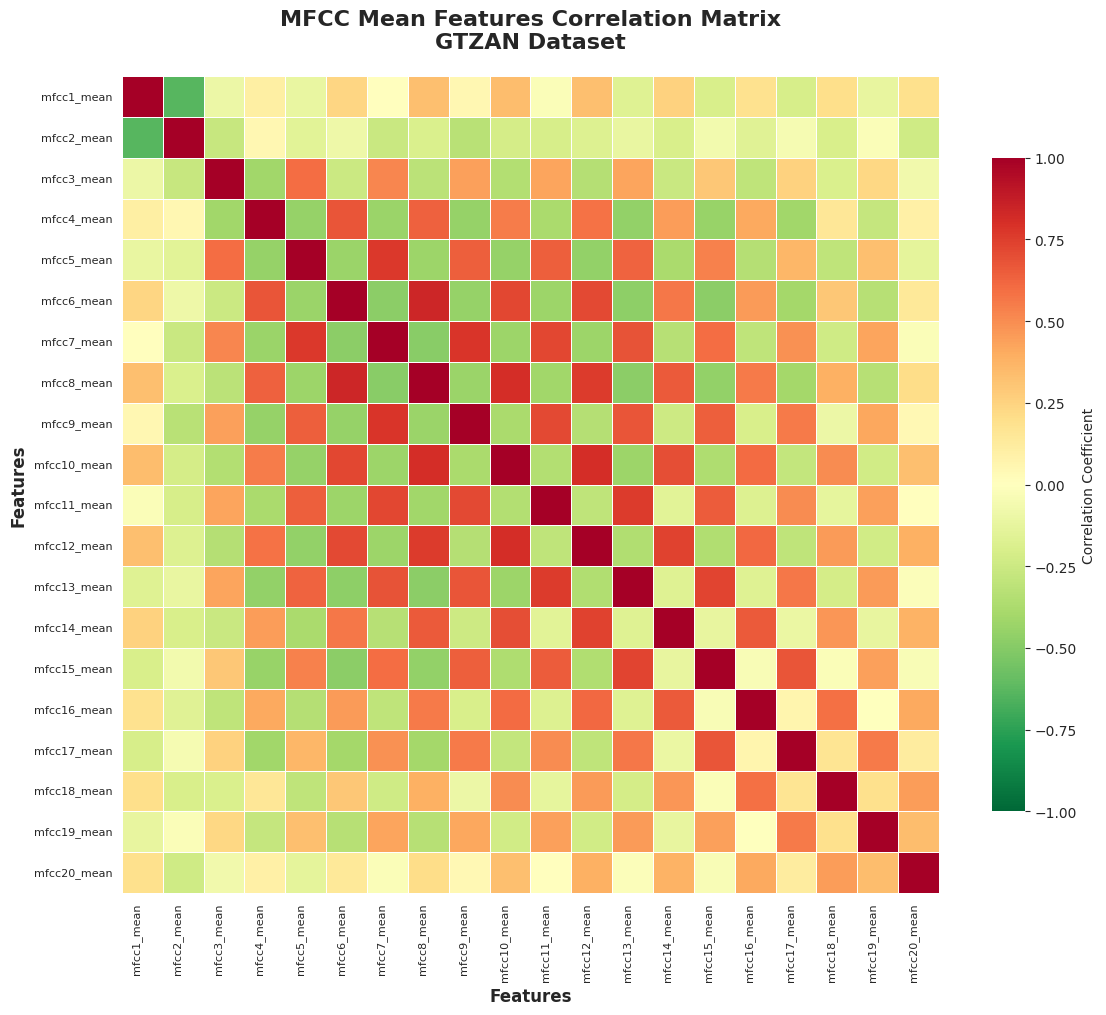

✓ Saved: correlation_mfcc_mean_indian_music.png


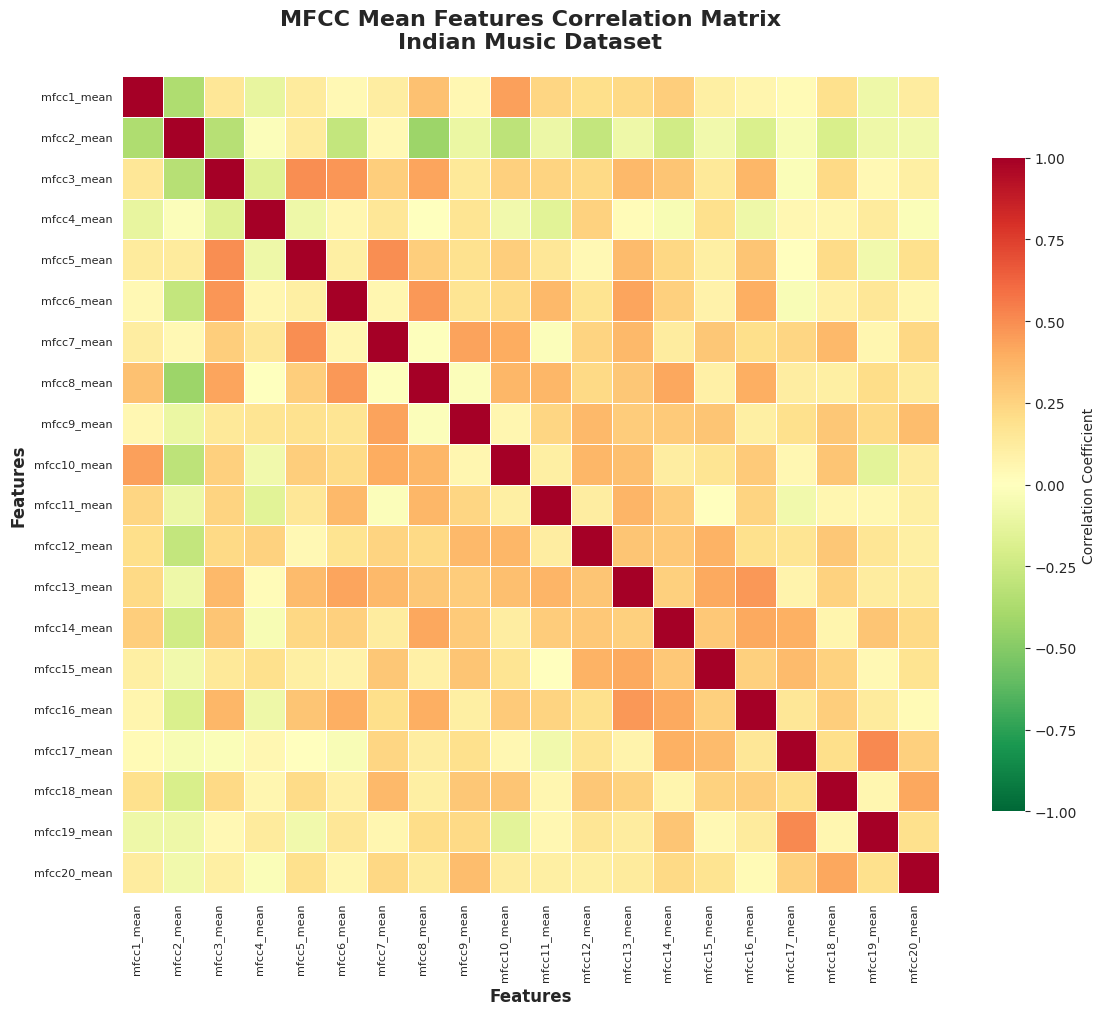

✓ Saved: correlation_mfcc_mean_ludwig.png


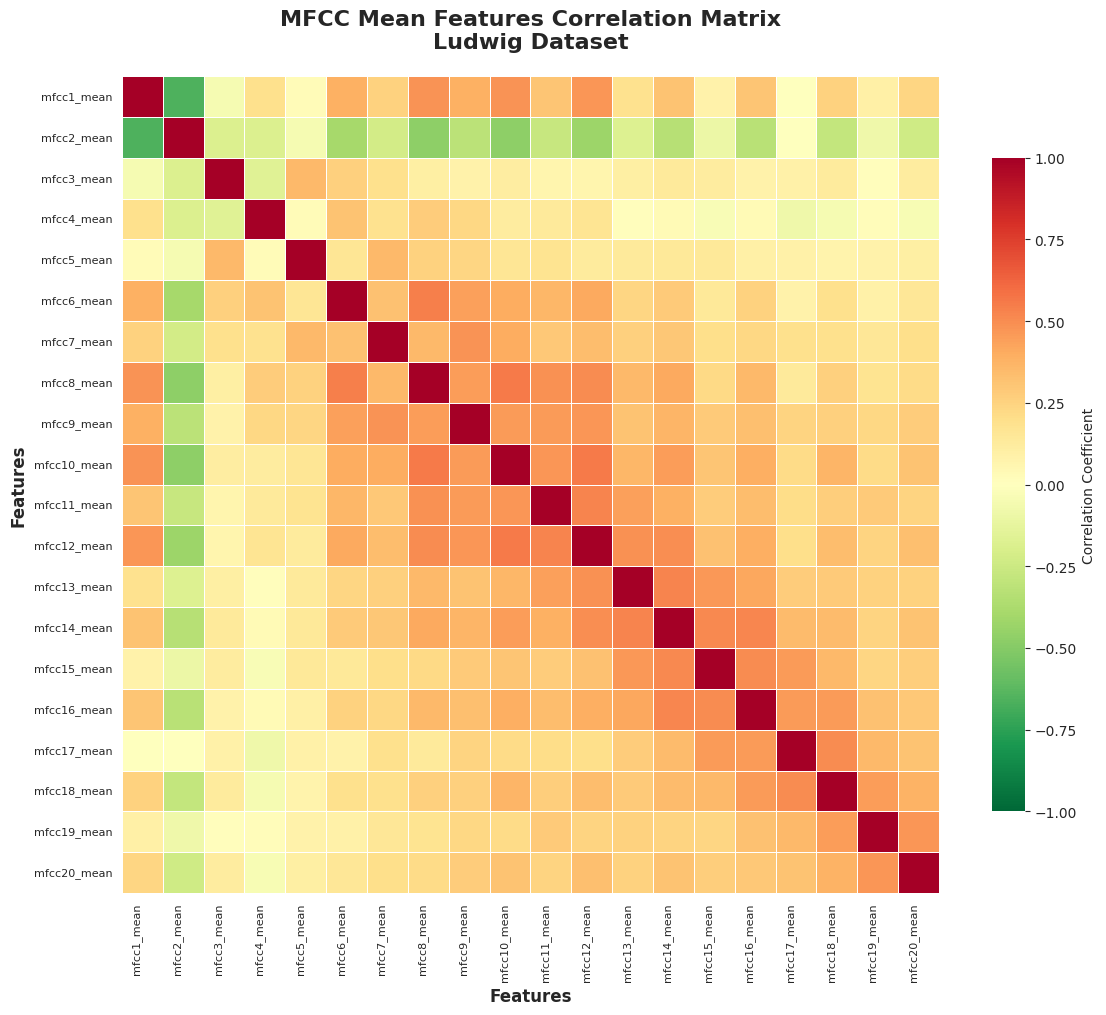

In [7]:
def plot_correlation_heatmap(corr_matrix, title, output_path, figsize=(14, 12)):
    """
    Plot correlation matrix as a heatmap.
    """
    plt.figure(figsize=figsize)
    
    # Create mask for upper triangle (optional - shows full matrix here)
    # mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot heatmap
    sns.heatmap(corr_matrix, 
                annot=False,  # Too many features to annotate
                cmap='RdYlGn_r',
                center=0,
                vmin=-1, vmax=1,
                square=True,
                linewidths=0.5,
                cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8})
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {os.path.basename(output_path)}")
    plt.show()

# Plot MFCC mean correlation heatmaps for each dataset
print("\n📊 Generating MFCC Mean Correlation Heatmaps...\n")

for name, corr_matrix in mfcc_mean_matrices.items():
    title = f"MFCC Mean Features Correlation Matrix\n{name} Dataset"
    output_path = os.path.join(output_dir, f"correlation_mfcc_mean_{name.lower().replace(' ', '_')}.png")
    plot_correlation_heatmap(corr_matrix, title, output_path, figsize=(12, 10))

### 5.2 MFCC Std Features Correlation


📊 Generating MFCC Std Correlation Heatmaps...

✓ Saved: correlation_mfcc_std_fma_small.png
✓ Saved: correlation_mfcc_std_fma_small.png


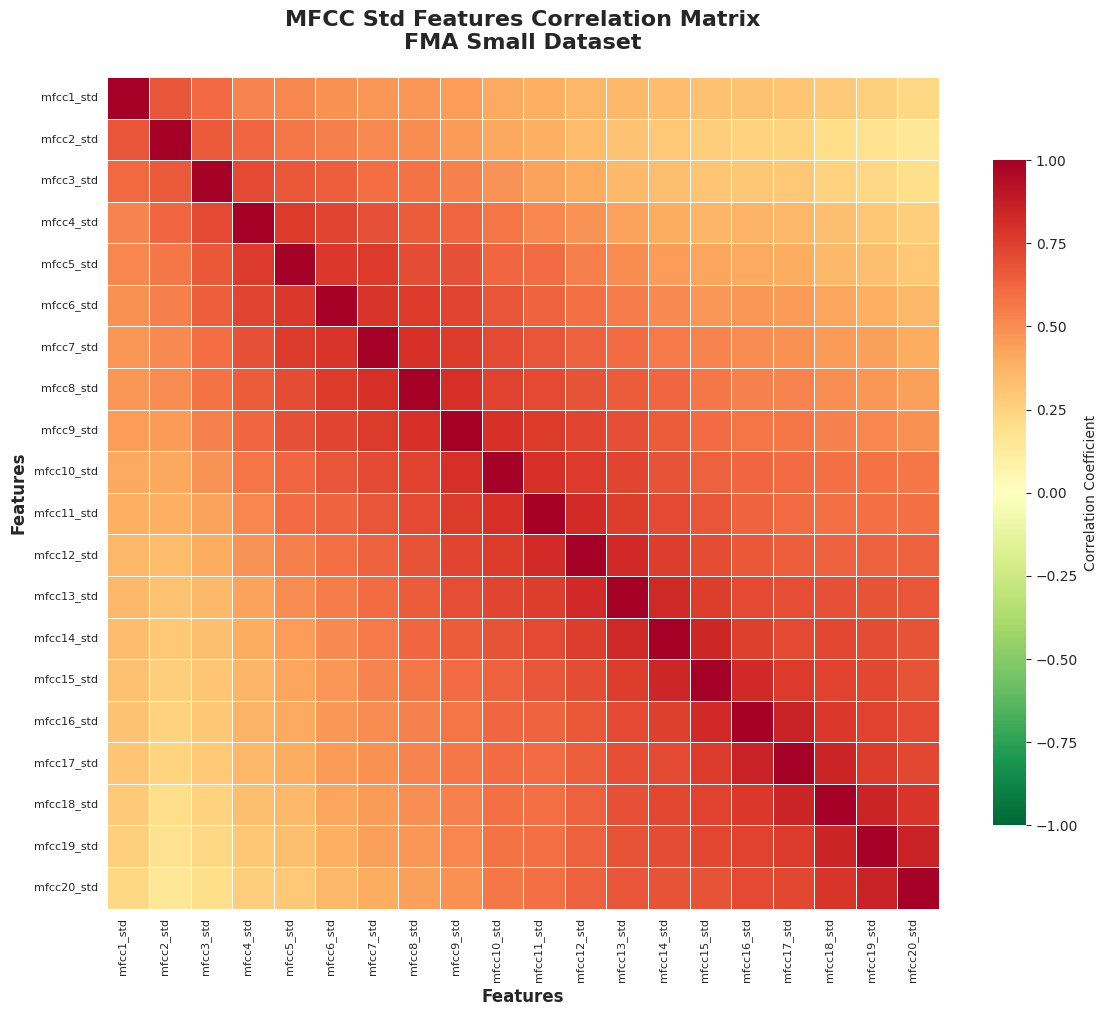

✓ Saved: correlation_mfcc_std_fma_medium.png


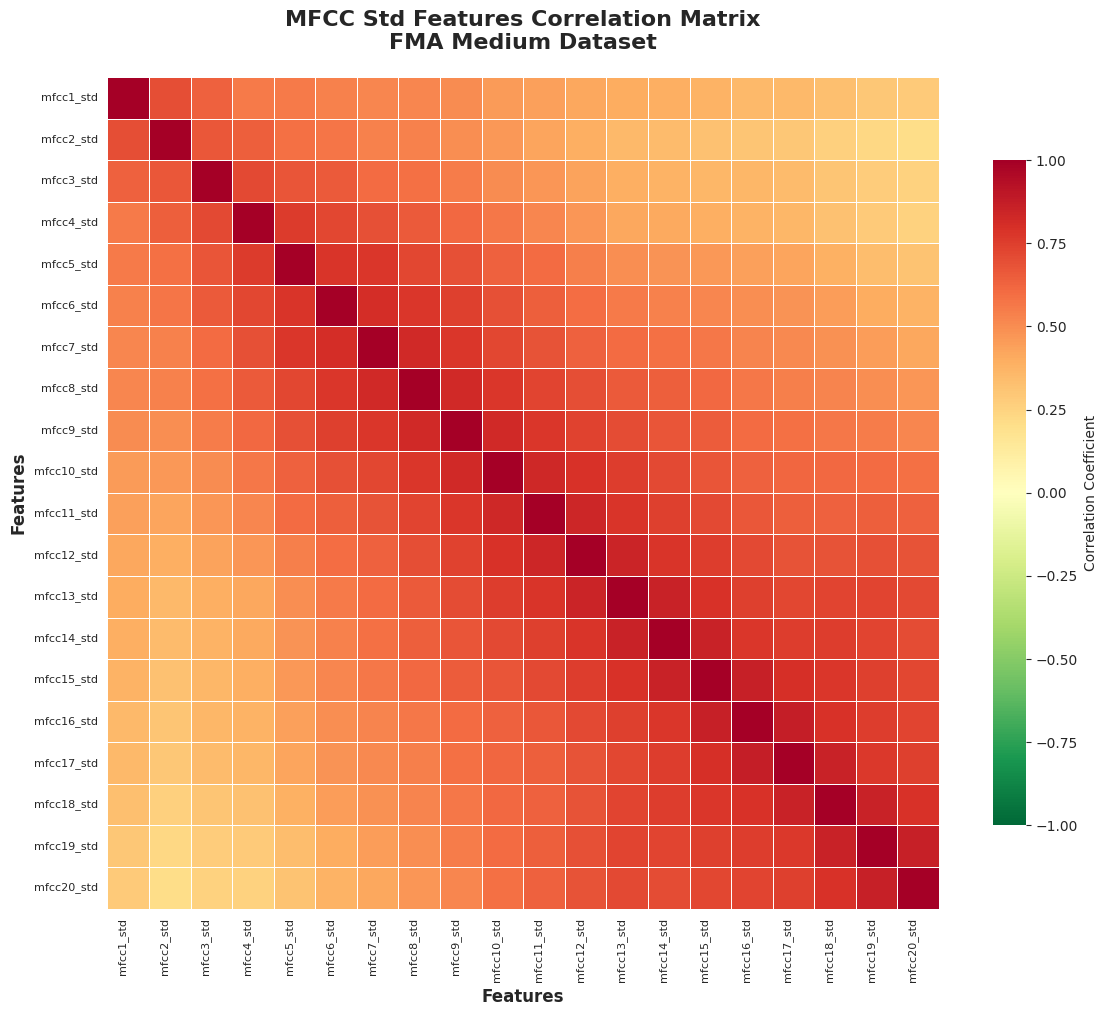

✓ Saved: correlation_mfcc_std_gtzan.png


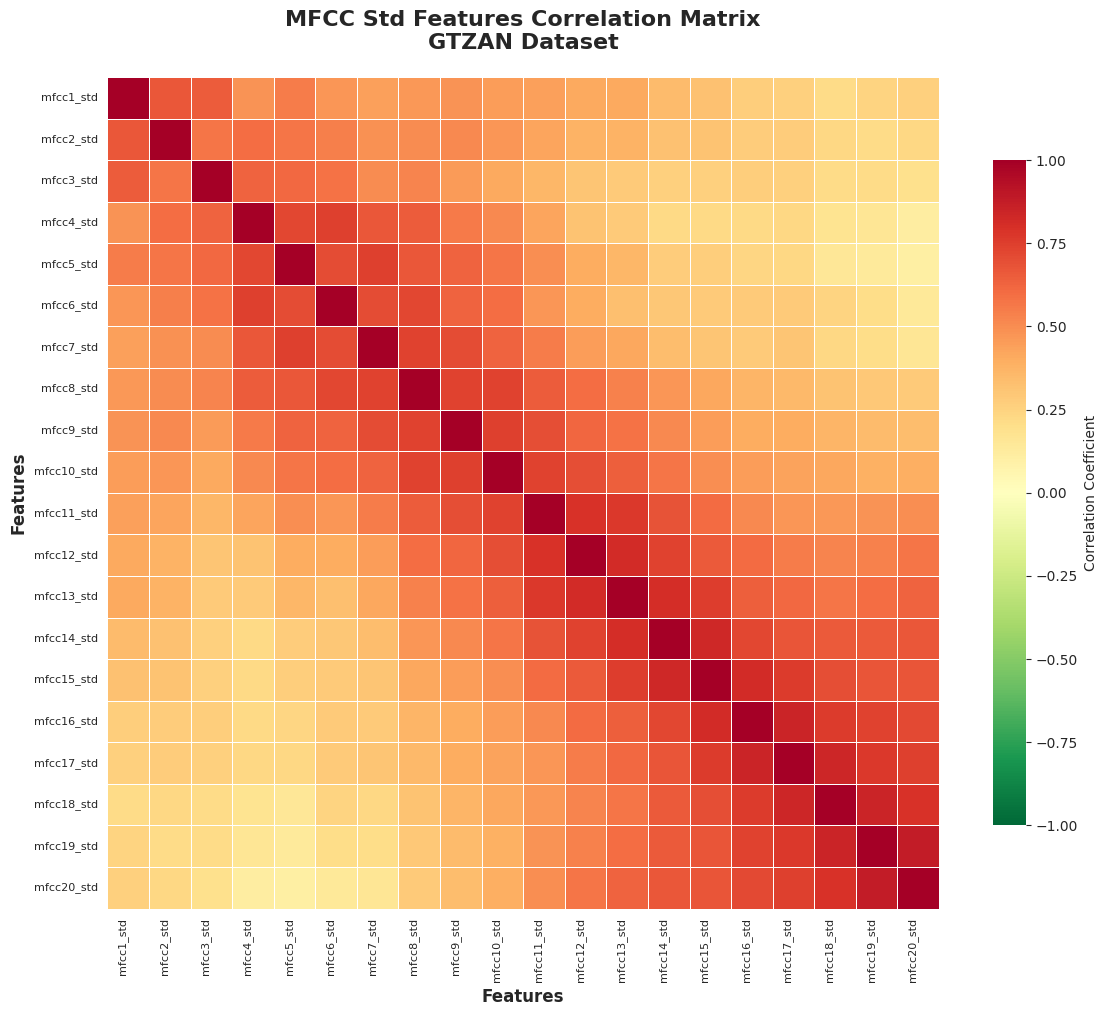

✓ Saved: correlation_mfcc_std_indian_music.png


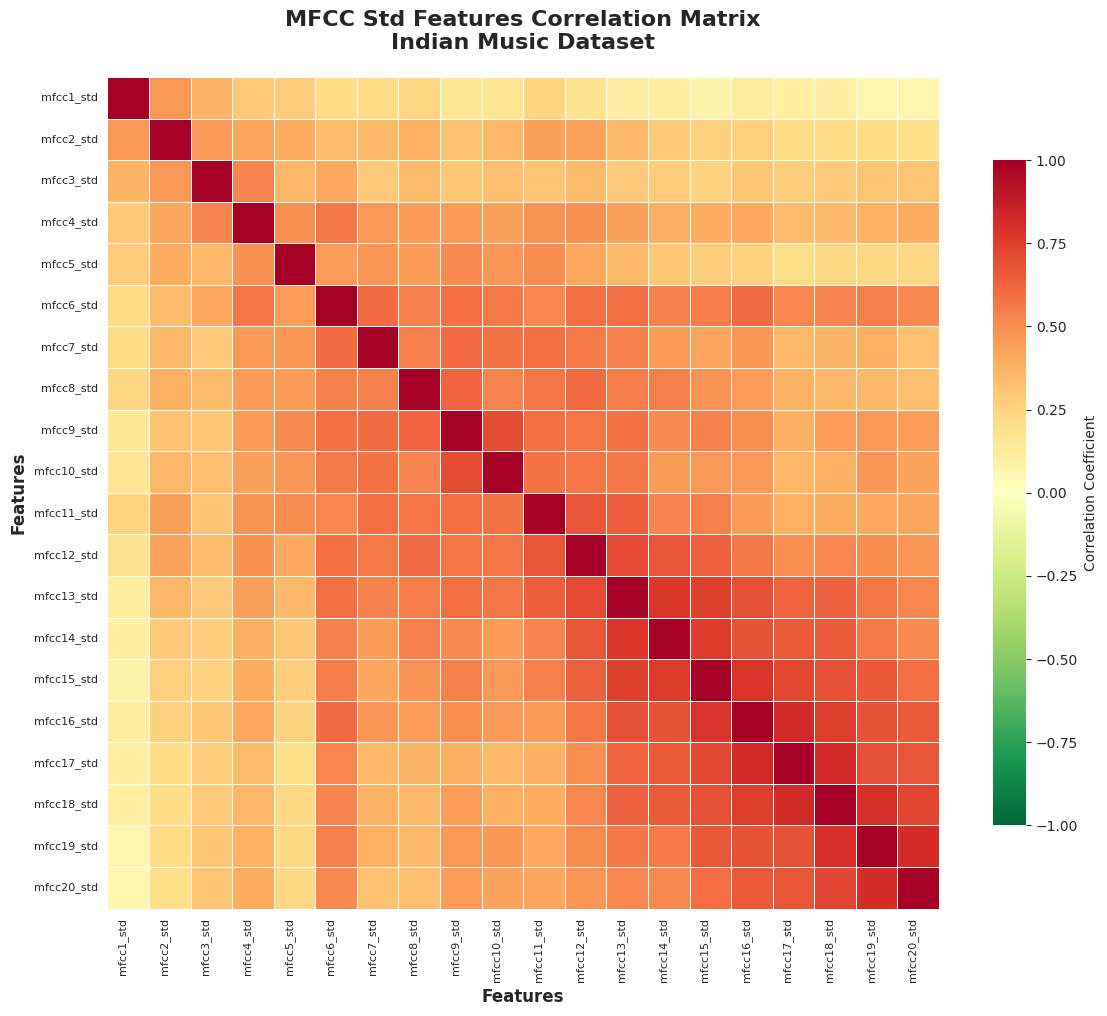

✓ Saved: correlation_mfcc_std_ludwig.png


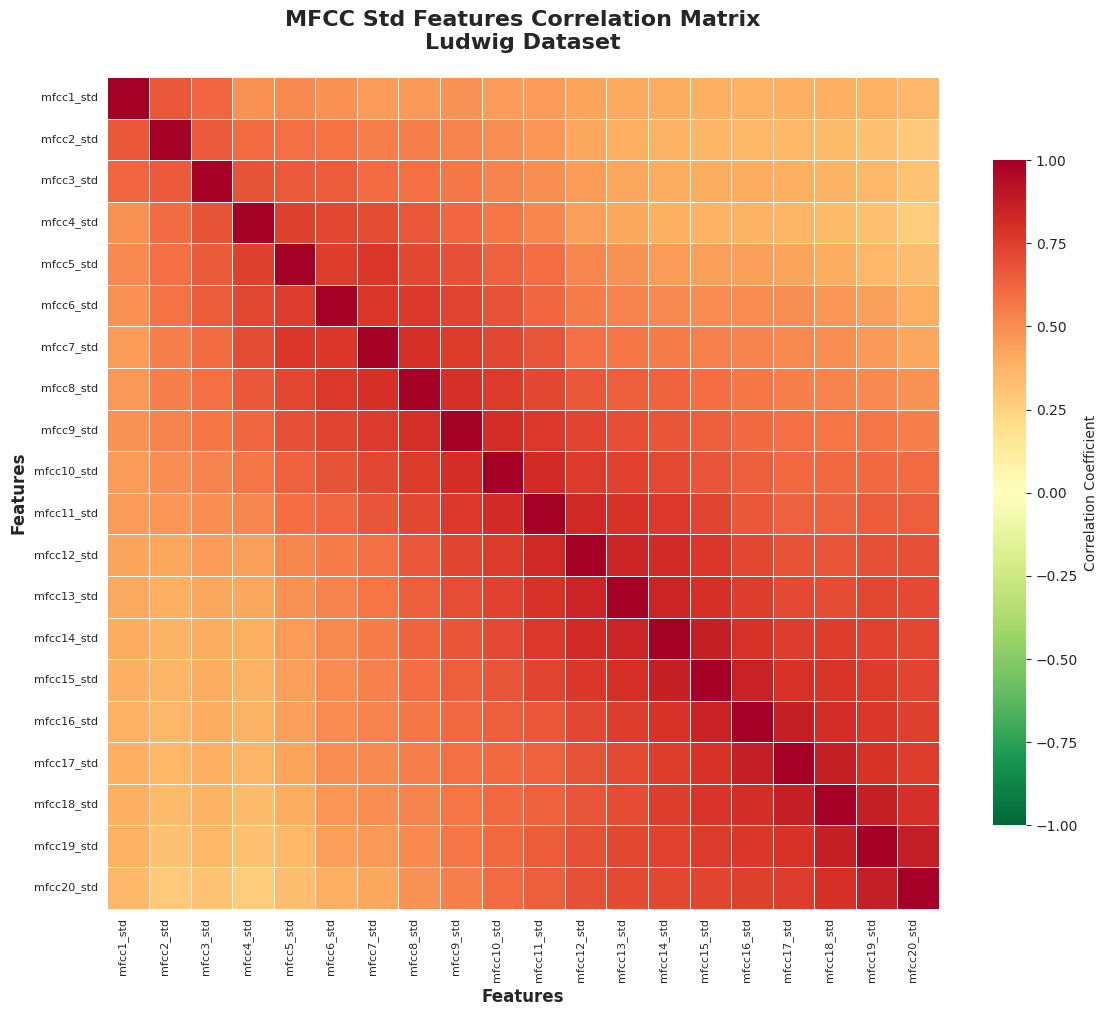

In [8]:
# Plot MFCC std correlation heatmaps for each dataset
print("\n📊 Generating MFCC Std Correlation Heatmaps...\n")

for name, corr_matrix in mfcc_std_matrices.items():
    title = f"MFCC Std Features Correlation Matrix\n{name} Dataset"
    output_path = os.path.join(output_dir, f"correlation_mfcc_std_{name.lower().replace(' ', '_')}.png")
    plot_correlation_heatmap(corr_matrix, title, output_path, figsize=(12, 10))

### 5.3 Combined Dataset: MFCC Mean Correlation

Analyze correlation patterns across all datasets combined

Combined dataset: 37,774 tracks, 76 features
MFCC mean features: 20
✓ Saved: correlation_mfcc_mean_combined.png
✓ Saved: correlation_mfcc_mean_combined.png


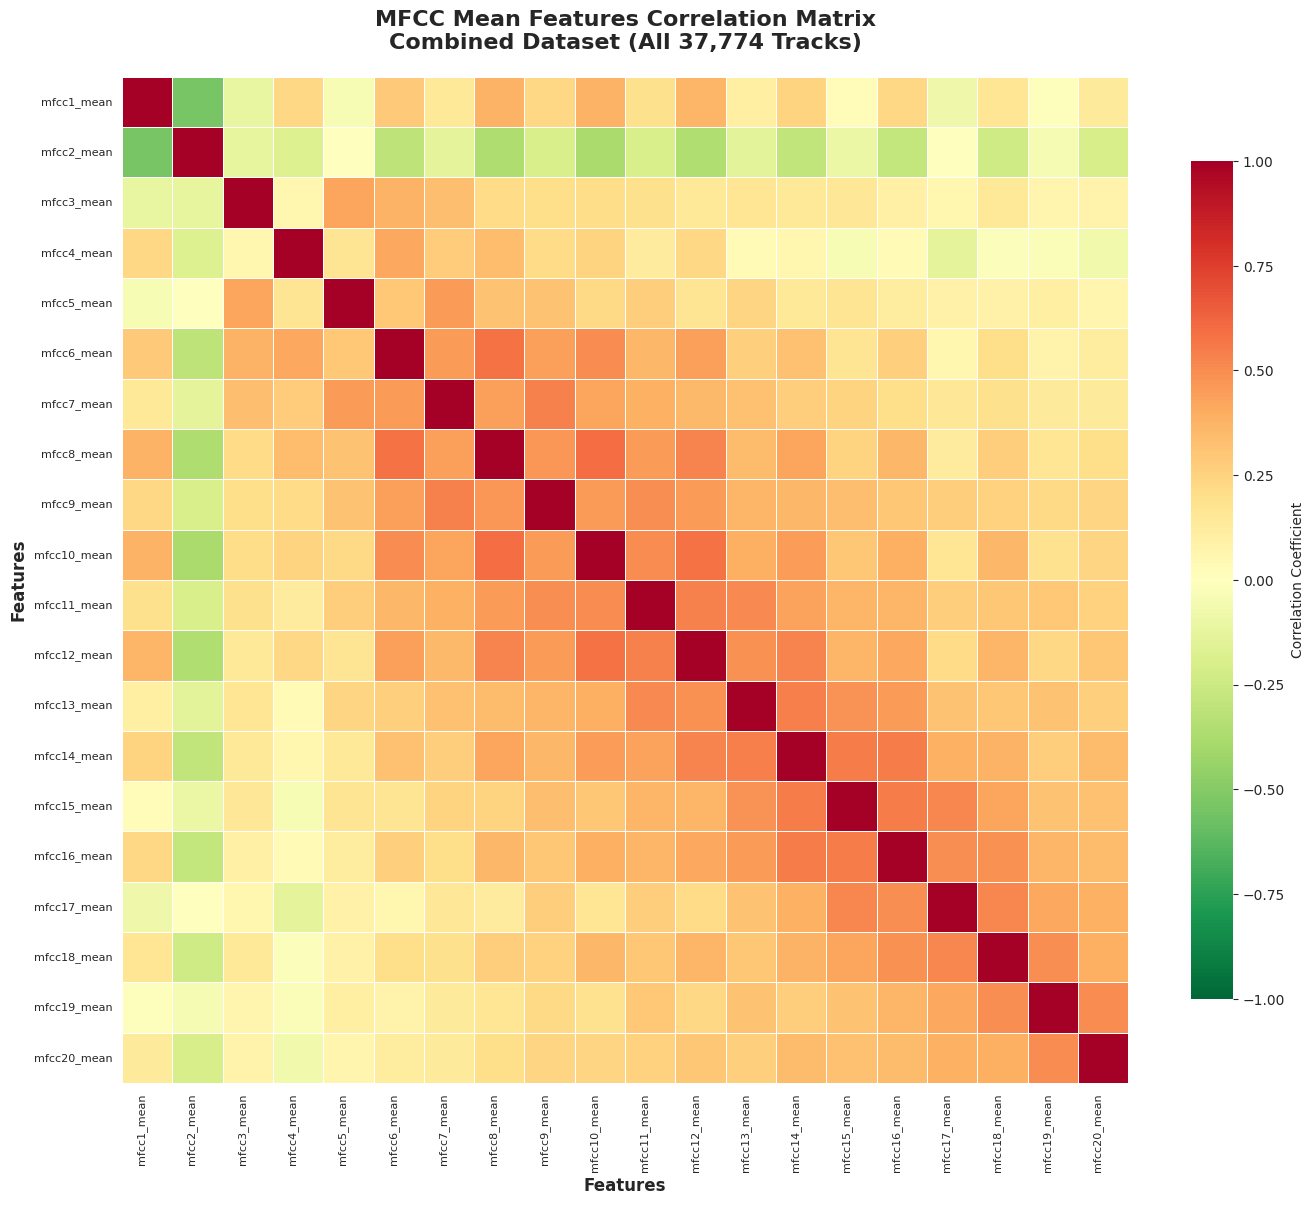

In [9]:
# Combine all datasets
combined_df = pd.concat(data.values(), ignore_index=True)
print(f"Combined dataset: {combined_df.shape[0]:,} tracks, {combined_df.shape[1]} features")

# Get MFCC mean columns
mfcc_mean_cols = [col for col in combined_df.columns if 'mfcc' in col and '_mean' in col]
print(f"MFCC mean features: {len(mfcc_mean_cols)}")

# Compute correlation matrix
combined_mfcc_mean_corr = combined_df[mfcc_mean_cols].corr()

# Plot
title = f"MFCC Mean Features Correlation Matrix\nCombined Dataset (All 37,774 Tracks)"
output_path = os.path.join(output_dir, "correlation_mfcc_mean_combined.png")
plot_correlation_heatmap(combined_mfcc_mean_corr, title, output_path, figsize=(14, 12))

## 6. Correlation Statistics Summary

In [10]:
def correlation_statistics(corr_matrix):
    """
    Compute correlation statistics (excluding diagonal).
    """
    # Get upper triangle values (excluding diagonal)
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    correlations = upper_triangle.stack()
    
    stats = {
        'Mean': correlations.mean(),
        'Median': correlations.median(),
        'Std': correlations.std(),
        'Min': correlations.min(),
        'Max': correlations.max(),
        'Q25': correlations.quantile(0.25),
        'Q75': correlations.quantile(0.75),
        'Pairs_>0.9': (correlations.abs() > 0.9).sum(),
        'Pairs_>0.8': (correlations.abs() > 0.8).sum(),
        'Pairs_>0.7': (correlations.abs() > 0.7).sum()
    }
    
    return stats

# Compute statistics for MFCC mean features
print("\n" + "="*80)
print("📈 CORRELATION STATISTICS: MFCC MEAN FEATURES")
print("="*80)

stats_summary = []
for name, corr_matrix in mfcc_mean_matrices.items():
    stats = correlation_statistics(corr_matrix)
    stats['Dataset'] = name
    stats_summary.append(stats)
    
    print(f"\n{name}:")
    print(f"  Mean correlation: {stats['Mean']:.3f}")
    print(f"  Median correlation: {stats['Median']:.3f}")
    print(f"  Max correlation: {stats['Max']:.3f}")
    print(f"  Pairs with |r| > 0.9: {stats['Pairs_>0.9']}")
    print(f"  Pairs with |r| > 0.8: {stats['Pairs_>0.8']}")
    print(f"  Pairs with |r| > 0.7: {stats['Pairs_>0.7']}")

# Create DataFrame
stats_df = pd.DataFrame(stats_summary)
stats_df = stats_df[['Dataset', 'Mean', 'Median', 'Max', 'Pairs_>0.9', 'Pairs_>0.8', 'Pairs_>0.7']]

print("\n" + "="*80)
print("Summary Table:")
print("="*80)
print(stats_df.to_string(index=False))


📈 CORRELATION STATISTICS: MFCC MEAN FEATURES

FMA Small:
  Mean correlation: 0.247
  Median correlation: 0.277
  Max correlation: 0.643
  Pairs with |r| > 0.9: 0
  Pairs with |r| > 0.8: 0
  Pairs with |r| > 0.7: 0

FMA Medium:
  Mean correlation: 0.246
  Median correlation: 0.281
  Max correlation: 0.602
  Pairs with |r| > 0.9: 0
  Pairs with |r| > 0.8: 0
  Pairs with |r| > 0.7: 0

GTZAN:
  Mean correlation: 0.077
  Median correlation: -0.026
  Max correlation: 0.837
  Pairs with |r| > 0.9: 0
  Pairs with |r| > 0.8: 3
  Pairs with |r| > 0.7: 13

Indian Music:
  Mean correlation: 0.155
  Median correlation: 0.166
  Max correlation: 0.514
  Pairs with |r| > 0.9: 0
  Pairs with |r| > 0.8: 0
  Pairs with |r| > 0.7: 0

Ludwig:
  Mean correlation: 0.212
  Median correlation: 0.249
  Max correlation: 0.557
  Pairs with |r| > 0.9: 0
  Pairs with |r| > 0.8: 0
  Pairs with |r| > 0.7: 0

Summary Table:
     Dataset     Mean    Median      Max  Pairs_>0.9  Pairs_>0.8  Pairs_>0.7
   FMA Small 0.24

## 7. Save Correlation Analysis Results

In [11]:
# Save high correlation pairs for each dataset
for name, df_corr in high_correlations.items():
    filename = f"high_correlations_{name.lower().replace(' ', '_')}.csv"
    filepath = os.path.join(output_dir, filename)
    df_corr.to_csv(filepath, index=False)
    print(f"✓ Saved: {filename}")

# Save MFCC mean high correlations
for name, df_corr in mfcc_mean_high_corr.items():
    filename = f"mfcc_mean_high_correlations_{name.lower().replace(' ', '_')}.csv"
    filepath = os.path.join(output_dir, filename)
    df_corr.to_csv(filepath, index=False)
    print(f"✓ Saved: {filename}")

# Save statistics summary
stats_file = os.path.join(output_dir, 'correlation_statistics_summary.csv')
stats_df.to_csv(stats_file, index=False)
print(f"✓ Saved: correlation_statistics_summary.csv")

✓ Saved: high_correlations_fma_small.csv
✓ Saved: high_correlations_fma_medium.csv
✓ Saved: high_correlations_gtzan.csv
✓ Saved: high_correlations_indian_music.csv
✓ Saved: high_correlations_ludwig.csv
✓ Saved: mfcc_mean_high_correlations_fma_small.csv
✓ Saved: mfcc_mean_high_correlations_fma_medium.csv
✓ Saved: mfcc_mean_high_correlations_gtzan.csv
✓ Saved: mfcc_mean_high_correlations_indian_music.csv
✓ Saved: mfcc_mean_high_correlations_ludwig.csv
✓ Saved: correlation_statistics_summary.csv


## 8. PCA Justification Analysis

In [12]:
print("\n" + "="*80)
print("📋 PHASE 4: CORRELATION ANALYSIS - SUMMARY & PCA JUSTIFICATION")
print("="*80)

# Calculate overall statistics
total_high_corr = sum(len(df) for df in high_correlations.values())
avg_high_corr = total_high_corr / len(high_correlations)

mfcc_total_high_corr = sum(len(df) for df in mfcc_mean_high_corr.values())
mfcc_avg_high_corr = mfcc_total_high_corr / len(mfcc_mean_high_corr) if mfcc_mean_high_corr else 0

print(f"\n📊 MULTICOLLINEARITY FINDINGS:")
print(f"   • Average high correlations per dataset (all features): {avg_high_corr:.1f} pairs")
print(f"   • Average high correlations per dataset (MFCC mean): {mfcc_avg_high_corr:.1f} pairs")
print(f"   • Total datasets analyzed: {len(data)}")

# Analyze MFCC mean correlation patterns
combined_stats = correlation_statistics(combined_mfcc_mean_corr)
print(f"\n🔍 COMBINED DATASET (MFCC MEAN FEATURES):")
print(f"   • Mean correlation: {combined_stats['Mean']:.3f}")
print(f"   • Median correlation: {combined_stats['Median']:.3f}")
print(f"   • Maximum correlation: {combined_stats['Max']:.3f}")
print(f"   • Feature pairs with |r| > 0.9: {combined_stats['Pairs_>0.9']}")
print(f"   • Feature pairs with |r| > 0.8: {combined_stats['Pairs_>0.8']}")
print(f"   • Feature pairs with |r| > 0.7: {combined_stats['Pairs_>0.7']}")

# Get top correlated pairs from combined dataset
combined_high_corr = find_high_correlations(combined_mfcc_mean_corr, threshold=0.9)
print(f"\n🎯 TOP 10 MOST CORRELATED MFCC MEAN FEATURE PAIRS (Combined Dataset):")
if len(combined_high_corr) > 0:
    for idx, row in combined_high_corr.head(10).iterrows():
        print(f"   {idx+1}. {row['Feature_1']} ↔ {row['Feature_2']}: r = {row['Correlation']:.4f}")
else:
    print("   No feature pairs with |r| > 0.9 found.")

# PCA Justification
print(f"\n💡 PCA JUSTIFICATION:")
if combined_stats['Pairs_>0.9'] > 10:
    print(f"   ✅ STRONGLY JUSTIFIED: {combined_stats['Pairs_>0.9']} feature pairs show redundancy (|r| > 0.9)")
    print(f"   ✅ High multicollinearity detected in MFCC features")
    print(f"   ✅ Dimensionality reduction will eliminate redundancy without information loss")
elif combined_stats['Pairs_>0.8'] > 20:
    print(f"   ⚡ JUSTIFIED: {combined_stats['Pairs_>0.8']} feature pairs show strong correlation (|r| > 0.8)")
    print(f"   ⚡ Moderate multicollinearity present")
    print(f"   ⚡ PCA will improve model efficiency and reduce overfitting")
else:
    print(f"   ⚠️  LIMITED JUSTIFICATION: Moderate correlation levels detected")
    print(f"   ⚠️  PCA may still help but benefits less pronounced")

print(f"\n📈 RECOMMENDATIONS:")
print(f"   1. Apply PCA to reduce 65+ features to ~20-30 principal components")
print(f"   2. Retain 95% of cumulative explained variance")
print(f"   3. Prioritize MFCC feature groups for dimensionality reduction")
print(f"   4. Validate clustering performance before/after PCA")

print("\n" + "="*80)
print("✅ PHASE 4 COMPLETE: Correlation Analysis & Multicollinearity Assessment")
print("="*80)


📋 PHASE 4: CORRELATION ANALYSIS - SUMMARY & PCA JUSTIFICATION

📊 MULTICOLLINEARITY FINDINGS:
   • Average high correlations per dataset (all features): 2.6 pairs
   • Average high correlations per dataset (MFCC mean): 0.0 pairs
   • Total datasets analyzed: 5

🔍 COMBINED DATASET (MFCC MEAN FEATURES):
   • Mean correlation: 0.233
   • Median correlation: 0.261
   • Maximum correlation: 0.598
   • Feature pairs with |r| > 0.9: 0
   • Feature pairs with |r| > 0.8: 0
   • Feature pairs with |r| > 0.7: 0

🎯 TOP 10 MOST CORRELATED MFCC MEAN FEATURE PAIRS (Combined Dataset):
   No feature pairs with |r| > 0.9 found.

💡 PCA JUSTIFICATION:
   ⚠️  LIMITED JUSTIFICATION: Moderate correlation levels detected
   ⚠️  PCA may still help but benefits less pronounced

📈 RECOMMENDATIONS:
   1. Apply PCA to reduce 65+ features to ~20-30 principal components
   2. Retain 95% of cumulative explained variance
   3. Prioritize MFCC feature groups for dimensionality reduction
   4. Validate clustering perfor